# 1. Least Significant Bit
---------------
Write a program that implements the least significant bit (LBS) algorithm to encode a text based message into an image file.

Keep the following requirements in mind:

- Limit your solution to PNG formatted images
- Begin to encode the text at the first pixel
- Check that you image contains enough bytes to encode the data
- Factor your code to run as both a standalone program and a module

Provide an example of using your code in a Jupyter notebook that shows the original image, the encoded image, and the extracted message. Please include the images required to run in in the directory.


Post an image with an hidden message to #showcase. Do not encrypt the message.

### Solution

Goal: Encode a text message into a PNG image by hiding each bit of the text in the least significant bits (LSB) of the image's pixel values. 


#### Code:
- **Encoding**: Message converted to binary (8-bit ASCII binary for each character). The significant bit of each pixel component is modified to match these bits.
- **Decoding**: The least significant bits from each component is read and the original message is reconstructed.
- **Termination**: Adds a null byte ('00000000') at the end of the encoded message as a terminator.


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


class LSBEncoder:
    def __init__(self, image_path):
        self.image = Image.open(image_path)
        self.pixels = np.array(self.image)
        self.height, self.width, _ = self.pixels.shape

    def text_to_bits(self, text):
        '''
        This function converts a string of text into a sequence of binary bits.

        Input: 
            text (str): The message to be encoded

        Returns:
            binary_text (str): the text in binary
        '''
        in_bin = [format(ord(c), '08b') for c in text]
        binary_text = ''.join(in_bin)
        return binary_text

    def bits_to_text(self, bits):
        '''
        This function converts a sequence of binary bits back into readable text.

        Input: 
            bits (str): The binary bits to be converted back to text.

        Returns:
            text (str): the readable text
        '''
        chars = [chr(int(bits[i:i+8], 2)) for i in range(0, len(bits), 8)] # reads every 8 bits as one char and converts to ASCII
        text = ''.join(chars)
        return text

    def encode(self, text, output_path):
        '''
        This function encodes a given text message into the image’s least significant bits and saves the modified image.
        
        Inputs:
            text (str): The message to hide within the image.
            output_path (str): The file path where the new encoded image will be saved.
        
        Returns:
            output_path: encoded image.
        '''
        # Convert the text to binary bits.
        bits = self.text_to_bits(text) + '00000000'  # Add a null byte as a terminator
        required_pixels = len(bits) + 1

        # Check if there’s enough space in the image to store the message.
        if required_pixels > self.width * self.height * 3:
            raise ValueError("Image does not contain enough bytes to encode the data.")
        
        flat_pixels = self.pixels.flatten().astype(np.uint8)  # Ensure uint8 type for each pixel value

        # Encode each bit of the message into the LSB of each pixel.
        for i, bit in enumerate(bits):
            # Cast each pixel as an int to avoid overflow, modify LSB, then cast back to uint8
            pixel_value = int(flat_pixels[i]) & ~1 | int(bit)
            flat_pixels[i] = np.uint8(pixel_value)  # Safely cast back to uint8
        
        encoded_pixels = flat_pixels.reshape(self.pixels.shape)
        encoded_image = Image.fromarray(encoded_pixels.astype('uint8'))
        encoded_image.save(output_path) # Save modified image to output_path.
        return output_path


    def decode(self):
        '''
        This function extracts the hidden text message from the LSBs of the image.
         
        Returns:
            message (str): The encoded message
        '''
        # Read each pixel’s LSB to reconstruct the hidden binary bits.
        flat_pixels = self.pixels.flatten()
        bits = ''.join([str(flat_pixels[i] & 1) for i in range(self.width * self.height * 3)])

        # Stop reading at a null byte (end of the message)
        null_terminator = bits.find('00000000')
        if null_terminator != -1:
            bits = bits[:null_terminator]

        # Converts the binary bits back into readable text 
        message = self.bits_to_text(bits)
        return message




### Usage


Original Message:
- Shhh, this is a secret! you are in BIG trouble! But it's ok I forgive you :P 

Extracted Message:
- Shhh, this is a secret! you are in BIG trouble! But it's ok I forgive you :P

Original Image


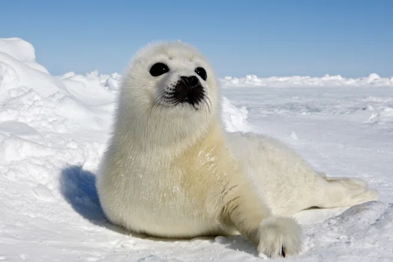

Encoded Image


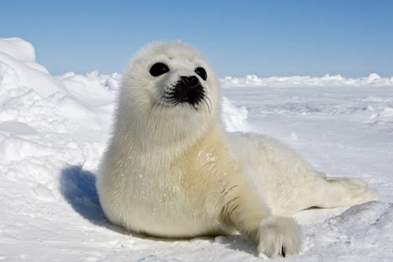

In [3]:
# Load the original image

original_image_path = 'images/og/seal.png'
encoded_image_path = 'images/results/encoded_seal.png'

# Alternate Image
#original_image_path = 'images/og/birkin.png'
#encoded_image_path = 'images/results/encoded_birkin.png'

#original_image_path = 'images/og/friendly_seal.png'
#encoded_image_path = 'images/results/encoded_friendly_seal.png'

message = "Shhh, this is a secret! you are in BIG trouble! But it's ok I forgive you :P "

# Encode the message
encoder = LSBEncoder(original_image_path)
encoder.encode(message, encoded_image_path)

# Decode the message
decoder = LSBEncoder(encoded_image_path)
extracted_message = decoder.decode()

print(f"\nOriginal Message:\n- {message}\n\nExtracted Message:\n- {extracted_message}\n")

# Display images and extracted message in the notebook
from IPython.display import display

scale = 0.3

print('Original Image')
og_image = Image.open(original_image_path)
display(og_image.resize(( int(og_image.width * scale), int(og_image.height * scale))))

print('Encoded Image')
enc_image = Image.open(encoded_image_path)
display(enc_image.resize(( int(enc_image.width * scale), int(enc_image.height * scale))))


# 2. Steganalysis
-----------------
Now that we can encode and decode our own messages in a photo using LSB, the question remains, how do we know if an image contains a hidden message. If a steganographical approach is sound, it should not be able to be detected by the human eye. However, by manipulating the image, we should be able to identify some clues that will incite further investigation.

![](assets/2022-05-03-15-37-52.png)

Develop a that employs an "Enchanced LSB" strategy, similar to what is described [here](http://www.guillermito2.net/stegano/tools/index.html) and [here](http://www.guillermito2.net/stegano/inplainview/index.html).  In this approach, all 7 high-level bits are eliminated and set to match the maximum value of the RGB value. That will give some high-intensity colors, making the LSBs of the original image to become very visible. This should allow you to visually identify if there is additional data embedded in your photo.

Provide an example of using your code in a Jupyter notebook that shows the original image, the encoded image, the enhanced LSB image, and the extracted message.

## Q2 Solution:

### "Enhanced LSB" Strategy:
Enhance visibility of any hidden data by eliiminating the high-level bits (leaving only the LSBs visible) and set them to the maximum RGB value.

### Background: 
>Information gathered from resources provided:
>
> **Visual Enhancement of LSBs**:
> The articles describe a visual attack where only the least significant bit (LSB) is preserved, and all other bits are removed. This manipulation leaves the LSB values visible by intensifying them, often setting 1 bits to the maximum (255) and 0 bits to zero. This approach creates a high-contrast image where hidden data patterns are more visible.
> 
> **Detecting Patterns in Embedded Data**:
> Both articles highlight that patterns in LSBs become noticeable when data is embedded. This is because the altered LSBs tend to form distinguishable, non-random structures compared to natural, random noise.
>
> **Use Cases for Steganalysis**:
> These articles suggest that "visual attacks" can reveal not only the presence of hidden data but also clues about the structure or type of embedded message. The enhanced LSB image can be a quick method to confirm if an image has been modified with hidden information.


### Implementation
For visual enhancement of LSB, the higher bits of each pixel are removed and the remaining LSBs are set to high intensity. This makes hidden data patterns more apparent to the naked eye.

### Step-by-Step Code
- Encode: Embed a sample message into the image using LSB steganography.
- Enhance LSBs: Visualize the LSBs to detect any hidden data.
- Decode: Verify the encoded message by extracting it from the image.

### Explanation of Each Step
- **Encoding**: The LSBEncoder class’s encode method embeds each bit of the message into the LSB of the image’s pixels, starting from the first pixel. After encoding, we save the modified image.

- **Enhancing LSBs**: The EnhancedLSBSteganalysis class’s enhance_lsb method visualizes the LSBs by removing the higher 7 bits and setting the LSBs to the maximum intensity (255) if the bit is 1. This creates a high-contrast image where patterns from the encoded data might appear, revealing any hidden information.

- **Decoding**: The decode method in LSBEncoder reads the LSBs of each pixel, reconstructing the binary sequence until it reaches a null byte (end of the message). This extracted binary sequence is then converted back to the original text.


In [4]:
class EnhancedLSBSteganalysis:
    def __init__(self, image_path):
        self.image = Image.open(image_path)
        self.pixels = np.array(self.image)
    
    def enhance_lsb(self):
        # Only keep LSBs 
        enhanced_pixels = (self.pixels & 1) * 255 # amplify LSBs
        enhanced_image = Image.fromarray(enhanced_pixels.astype('uint8'))
        return enhanced_image


### Usage

In [6]:
# Paths for input and output images

original_image_path = 'images/og/seal.png'
encoded_image_path = 'images/results/encoded_seal.png'
enhanced_lsb_image_path = 'images/results/enhanced_lsb_seal.png'

check_lsb_image_path = 'images/results/sanity_lsb_seal.png'

'''
# Alternative images
original_image_path = 'images/og/birkin.png'
encoded_image_path = 'images/results/encoded_birkin.png'
enhanced_lsb_image_path = 'images/results/enhanced_lsb_birkin.png'
'''
check_lsb_image_path = 'images/results/sanity_birkin.png'

# Message to encode
message = "I'm a secret, don't tell anyone plz >_< hush hush hush "

# Encode the message into the image
encoder = LSBEncoder(original_image_path)
encoder.encode(message, encoded_image_path)

# Enhance the LSBs of the encoded image
enhancer = EnhancedLSBSteganalysis(encoded_image_path)
enhanced_lsb_image = enhancer.enhance_lsb()
enhanced_lsb_image.save(enhanced_lsb_image_path)

# Decode the message to verify
decoder = LSBEncoder(encoded_image_path)
extracted_message = decoder.decode()

# missing last character
print(f"\nOriginal Message:\n- {message}\n\nExtracted Message:\n- {extracted_message}\n")

# Enhance the LSBs of the encoded image
check = EnhancedLSBSteganalysis(original_image_path)
check_lsb_image = check.enhance_lsb()
check_lsb_image.save(check_lsb_image_path)


Original Message:
- I'm a secret, don't tell anyone plz >_< hush hush hush 

Extracted Message:
- I'm a secret, don't tell anyone plz >_< hush hush hush



#### Results Display
- Original Image: Shows the original, unmodified image.
- Encoded Image: Displays the image after embedding the message (should look identical to the original).
- Enhanced LSB Image: Highlights the LSBs, potentially making hidden data patterns visible if present.

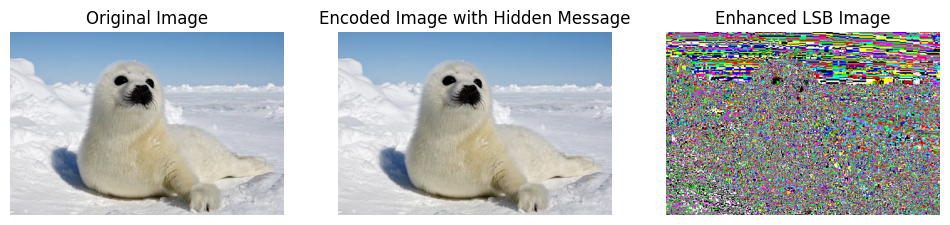

In [7]:
# Display the results
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(Image.open(original_image_path))
plt.axis('off')

# Encoded Image
plt.subplot(1, 3, 2)
plt.title("Encoded Image with Hidden Message")
plt.imshow(Image.open(encoded_image_path))
plt.axis('off')

# Enhanced LSB Image
plt.subplot(1, 3, 3)
plt.title("Enhanced LSB Image")
plt.imshow(enhanced_lsb_image)
plt.axis('off')

plt.show()

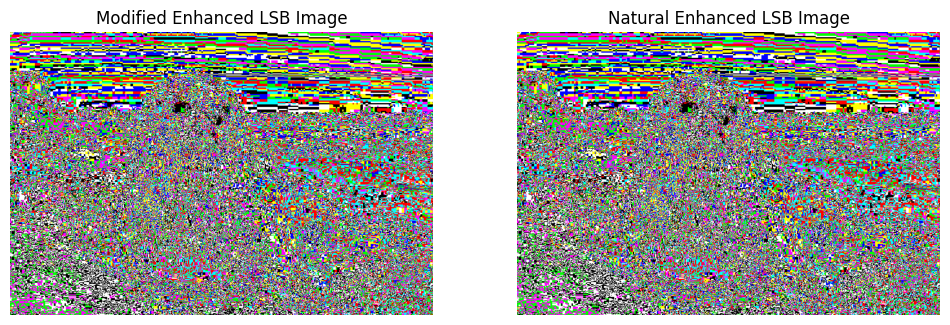

In [9]:
# compare original (natural) image to encoded. (they look the same sadly..)

plt.figure(figsize=(12, 4))

# Enhanced LSB Image
plt.subplot(1, 2, 1)
plt.title("Modified Enhanced LSB Image")
plt.imshow(enhanced_lsb_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Natural Enhanced LSB Image")
plt.imshow(check_lsb_image)
plt.axis('off')

plt.show()

## Assessment

- **Original Image**: This should look unchanged, as it’s the unmodified version before encoding.

- **Encoded Image with Hidden Message**: This also appears identical to the original, which is expected because the least significant bit (LSB) embedding method minimally alters pixel values, making visual changes imperceptible to the human eye.

- **Enhanced LSB Image**: The enhanced LSB image is displaying random-looking noise, which aligns with what we’d expect. If there is embedded data, patterns may sometimes become visible, especially if a large or structured message is encoded. Since the message in this case is relatively small, there may not be an obvious pattern, but the noise effect is a sign that LSBs are now highlighted.



# 3. Improved Steganalysis
-------------------------
Answer the following questions in a Jupyter Notebook with coded solutions to support your answers. You do not need to provide fully coded programs for the answers. Use a Jupyter Notebook as a playground to experiment with some ideas that will allow you to answer the questions. Steganalysis is a very difficult problem that is actively being researched with increasingly advanced approaches to counter increasingly advanced steganography. Use your implementations from Problem 1 and 2 to experiment as the baseline for your experimentation.

A. Is there a better scaling approach than "maxium value" that might might work better? Consider special circumstances, for example, what might best for grayscale images? Show some examples and comment on what you observed.

B.  A human can easily identify patterns in the enhanced LSB photos, but this approach does not scale for large photo analysis. Can you identify (or design) an automated approach to answering the question: Does this photo contain a hidden image?  You do not have to decode the message, only try to determine if the photo should undergo further analysis. Somethings to consider: Can you leverage the pattern you observe? Is the color value disribution skewed? Is there a regular distribution of pixels that you can identify? Some existing approaches utilize statistical measure such as mean, entropy, variance, contrast, energy, and standard deviation of the pixel values to identify discrepencies.

C. Based on your observations from B, what could be done to better hide the message in the image? Can you think of something that could eliminate the visually obvious pattern? Experiment with some ideas in the notebook.

### answers here

### Part A
Is there a better scaling approach than "maxium value" that might might work better? 
Consider special circumstances, for example, what might best for grayscale images? 
Show some examples and comment on what you observed.

### A. Solution
In the "maximum value" scaling approach, all LSBs are set to the maximum value (255). I will explore some other scaling techniques that could enhance LSB visibility. In greyscale images, intensity variations are more relevant than colour.

* See 'Extra Research' Below for where ideas came from :)

#### Testing Scaling Approaches:
In order to stay consistent with the LSB code written previously, I implemented the more accessible enhancement approaches:

- **Maximum Value Scaling (Baseline)**: Setting each LSB to 255 (like before).
- **Intensity-Based Scaling**: Scaling each LSB to a fraction of the original pixel value (e.g., 50% of its intensity).
- **Contrasted Scaling**: (similar to min-max scaling)Amplifying the LSB intensity by setting it based on specific ranges, such as boosting dark pixels' LSBs more than light pixels, which could help patterns stand out more.


In [10]:
'''
Class for comparing scaling approaches.
- note: (self.pixels & 1) is used to extract the least significant bit (LSB) of each pixel in the grayscale image. 
'''

class EnhancedLSBMethods:
    def __init__(self, image_path):
        self.image = Image.open(image_path).convert("L")  # Convert to grayscale
        self.pixels = np.array(self.image) # Image as np array

    # Baseline
    def maximum_value(self):
        '''
        Maximum Value Scaling
        Sets each LSB to the maximum intensity (255) if it’s 1, and 0 if it’s 0.
        '''
        return (self.pixels & 1) * 255

    def intensity_based(self, scale_factor=0.5):
        '''
        Scales each LSB by a percentage of the original pixel’s intensity.
        '''
        scaled = (self.pixels & 1) * (self.pixels * scale_factor) * 255 
        scaled = scaled.astype(np.uint8)
        return scaled

    def contrasted(self):
        '''
        Applies a conditional scaling where darker pixels with LSBs of 1 are boosted more than lighter pixels.
        Selective emphasis.
        '''
        alt_pixels = np.zeros_like(self.pixels)
        alt_pixels[(self.pixels < 128) & (self.pixels & 1 == 1)] = 200  # Boost dark areas with LSB 1
        alt_pixels[(self.pixels >= 128) & (self.pixels & 1 == 1)] = 100  # Moderate boost for light areas
        return alt_pixels



### Usage

#### For Greyscale Image:

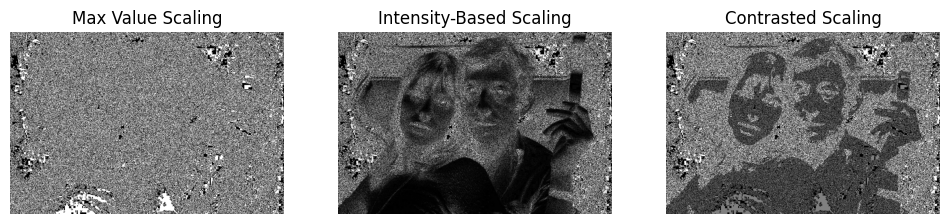

In [11]:
# Load the grayscale image and initialize steganalysis
image_path = 'images/og/birkin.png'
steganalysis = EnhancedLSBMethods(image_path)

# Apply different enhancement techniques
max_value = steganalysis.maximum_value()
intensity_based = steganalysis.intensity_based()
contrasted = steganalysis.contrasted()

# Display the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Max Value Scaling")
plt.imshow(max_value, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Intensity-Based Scaling")
plt.imshow(intensity_based, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Contrasted Scaling")
plt.imshow(contrasted, cmap="gray")
plt.axis("off")


plt.show()

#### For Colour Image

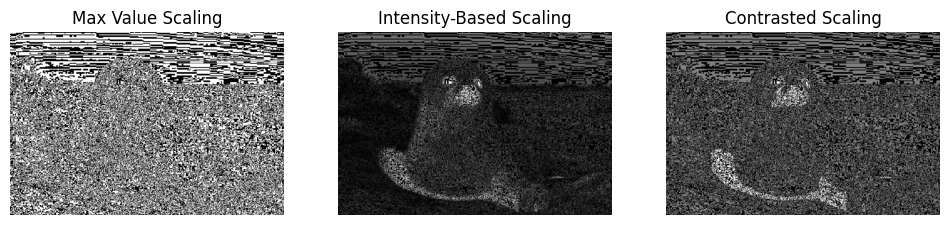

In [12]:
# Load the colour image and initialize steganalysis
image_path = 'images/og/seal.png'
steganalysis = EnhancedLSBMethods(image_path)

# Apply different enhancement techniques
max_value = steganalysis.maximum_value()
intensity_based = steganalysis.intensity_based()
contrasted = steganalysis.contrasted()

# Display the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Max Value Scaling")
plt.imshow(max_value, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Intensity-Based Scaling")
plt.imshow(intensity_based, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Contrasted Scaling")
plt.imshow(contrasted, cmap="gray")
plt.axis("off")


plt.show()

### Results/Analysis

**Max Value Scaling:**
Overly Noisy. This method highlights patterns but doesn’t retain the structural details needed to understand the context.

**Intensity-Based Scaling:**
More informative. This approach retains some of the original image’s tonal qualities because it balances LSB visibility with image structure. It makes LSB patterns appear more integrated with the underlying image, which might help in detecting subtle patterns without being too messy.
- Possible problem: This might be less effective for very dark or very light images since the scaling might cause some patterns to become indistinct.

**Contrasted Scaling:**
This approach selectively enhances LSBs based on pixel brightness. For example, dark pixels with an LSB of 1 are boosted more than light pixels, making certain patterns more apparent, especially with varying intensities. This can reveal LSB patterns hidden in different brightness regions.

### Conclusion
Intensity-based scaling and contrasted scaling may work better than the maximum value approach, especially when the image has subtle brightness variations. For greyscale images, intensity-based scaling may be better. These methods balance the contrast of the LSBs with the original image's grayscale tones, making it easier to detect embedded data without overwhelming the visual.

### Limitations:
My aproach was based on my implementation of LSB, but in the future I would like to test more methods by changing the bit-vales (ex: test 2-bit or 3-bit LSB).

### Problem B:
Identify (or design) an automated approach to answering the question: Does this photo contain a hidden image? Determine if the photo should undergo further analysis.

>- Can you leverage the pattern you observe?
>- Is the color value disribution skewed?
>- Is there a regular distribution of pixels that you can identify?
>- Some existing approaches utilize statistical measure such as mean, entropy, variance, contrast, energy, and standard deviation of the pixel values to identify discrepencies.

### B. Solution

#### Automated LSB Pattern Detection for Steganalysis
Goal:  Automatically determine if a photo contains hidden data in its LSBs.

### Approach:
Leverages statistical and pattern-based analysis on the LSB values. By examining specific metrics (such as entropy, variance, and pixel distribution patterns) across the LSB plane, we can identify discrepancies that may indicate hidden data.

> **Extract and Analyze LSBs**
> - Generate an LSB Matrix: Create a binary matrix (of the same dimensions as the image). Each pixel is represented by only its LSB value (0 or 1).
>   
> **Calculate Statistical Metrics**
> 
> Find non-random patterns within the LSB matrix:
>  - **Entropy**: Measures randomness in the LSB matrix. 
>  - **Variance**: Calculates the variance of pixel values in the LSB matrix. 
>  - **Mean** of LSBs: The mean of the LSBs should be around 0.5 for natural images.
>  - **Frequency Distribution** (of Pixel Blocks): Divide matrix into blocks and compute the frequency of 0s and 1s within each block.
>   

In [13]:
from scipy.stats import entropy

class LSBSteganalysis:
    def __init__(self, image_path):
        self.image = Image.open(image_path)
        self.pixels = np.array(self.image)

    def extract_lsb_matrix(self):
        '''
        For each pixel, keep only the least significant bit (LSB) and ignore the other bits. Use this to create a binary matrix. 
        '''
        lsb_matrix = self.pixels & 1
        avg = lsb_matrix.mean(axis=2)  # Averaging across color channels
        return avg

    def compute_metrics(self, lsb_matrix):
        '''
        Calculate statistical metrics that can indicate non-random patterns within the LSB matrix. 
        '''
        flat_lsb = lsb_matrix.flatten()
        
        # Entropy
        lsb_entropy = entropy(np.bincount(flat_lsb.astype(int)))

        # Mean
        lsb_mean = np.mean(flat_lsb)
        
        # Variance
        lsb_variance = np.var(flat_lsb)

        return lsb_mean, lsb_variance, lsb_entropy

    def analyze_blocks(self, lsb_matrix, block_size=8):
        '''
        Divide the LSB matrix into blocks and compute frequencies of 1s and 0s.
        '''
        h, w = lsb_matrix.shape
        block_frequencies = []
        
        for i in range(0, h, block_size):
            for j in range(0, w, block_size):
                block = lsb_matrix[i:i+block_size, j:j+block_size]
                freq = np.mean(block)
                block_frequencies.append(freq)
        
        return np.mean(block_frequencies), np.var(block_frequencies)



### Usage

In [14]:
# Get image
image_path = 'images/results/encoded_seal.png'
steganalysis = LSBSteganalysis(image_path)

# Extract LSB Matrix
lsb_matrix = steganalysis.extract_lsb_matrix()

# Compute Metrics
lsb_mean, lsb_variance, lsb_entropy = steganalysis.compute_metrics(lsb_matrix)
block_mean, block_variance = steganalysis.analyze_blocks(lsb_matrix)

# Display Results
print("Mean of LSBs:", lsb_mean)
print("Variance of LSBs:", lsb_variance)
print("Entropy of LSBs:", lsb_entropy)
print("Block Mean of LSBs:", block_mean)
print("Block Variance of LSBs:", block_variance)


Mean of LSBs: 0.622995311791976
Variance of LSBs: 0.04819825387324186
Entropy of LSBs: 0.38490674525990815
Block Mean of LSBs: 0.6229924531134515
Block Variance of LSBs: 0.00855060552824098


### Conclusion

The results indicate potential hidden data:
- The mean of LSBs is significantly above 0.5, suggesting a bias in LSB values.
- The low entropy indicates a lack of randomness, consistent with hidden information.
- The very low block variance shows a high uniformity across regions, which is unlikely in natural images and may suggest data encoding.

These observations collectively suggest that the image likely contains hidden data. 

### Test on Natural Image

In [15]:
# Get image
image_path = 'images/og/birkin.png'
steganalysis = LSBSteganalysis(image_path)

# Extract LSB Matrix
lsb_matrix = steganalysis.extract_lsb_matrix()

# Compute Metrics
lsb_mean, lsb_variance, lsb_entropy = steganalysis.compute_metrics(lsb_matrix)
block_mean, block_variance = steganalysis.analyze_blocks(lsb_matrix)

# Display Results
print("Mean of LSBs:", lsb_mean)
print("Variance of LSBs:", lsb_variance)
print("Entropy of LSBs:", lsb_entropy)
print("Block Mean of LSBs:", block_mean)
print("Block Variance of LSBs:", block_variance)


Mean of LSBs: 0.6244142373098069
Variance of LSBs: 0.1383829625122118
Entropy of LSBs: 0.692965369121029
Block Mean of LSBs: 0.6242326614862268
Block Variance of LSBs: 0.006097348167739844


#### Conclusion
Both encoded and natural (non-encoded) images are showing similar metrics, which indicates that the detection criteria may not be sensitive enough to distinguish between them. A different approach to either encoding, or testing sensitivity should be implemented.

Possible reasons:
- The LSB patterns in natural images might already have some non-random properties due to compression or image content, causing them to resemble encoded images statistically.
- Encoding strategy might not produce significant statistical differences in the LSB metrics.
- The testing metrics (Chi-square test, mean, variance, etc.) may not be sufficient for distinguishing subtle steganography techniques.

### Problem C:
Based on your observations from B, what could be done to better hide the message in the image? Can you think of something that could eliminate the visually obvious pattern? Experiment with some ideas in the notebook.

### C. Solution

Possible techniques for hiding messages in the LSBs and avoiding detectable patterns:

>**[Randomized Embedding](https://ieeexplore.ieee.org/document/9886754)**:
> Randomly distribute bits throughout the image. This could help prevent uniform patterns and keeps the LSB distribution closer to natural randomness.
>
>**[Adaptive Embedding](https://www.researchgate.net/publication/220177204_Edge_Adaptive_Image_Steganography_Based_on_LSB_Matching_Revisited)**:
> Modify the embedding based on the pixel intensity or texture complexity. Embed more in 'textured' areas than smooth ones. 
>
>**[Bit Plane Spreading](https://www.ijcsit.com/docs/Volume%207/vol7issue3/ijcsit2016070331.pdf)**:
> Spread the message bits across different bit planes (not just the LSB) based on pixel intensity or location, which helps distribute changes more evenly across the image and reduces the clustering of 1s and 0s in the LSB.
>
>**[Noise Injection](https://www.iosrjen.org/Papers/vol2_issue3/T022473477.pdf)**:
> Add controlled noise to the LSBs after embedding to introduce a small degree of randomness, masking any patterns that might otherwise be visible or statistically detectable.

In [16]:
import random

class AdvancedLSBSteganography:
    def __init__(self, image_path, seed=42):
        self.image = Image.open(image_path)
        self.pixels = np.array(self.image)
        random.seed(seed)

    def text_to_bits(self, text):
        in_bin = [format(ord(c), '08b') for c in text]
        binary_text = ''.join(in_bin)
        return binary_text

    def bits_to_text(self, bits):
        chars = [chr(int(bits[i:i+8], 2)) for i in range(0, len(bits), 8)]
        return ''.join(chars)

    def randomize_indices(self, length):
        # Generate randomized indices based on the length of the flattened image array
        indices = list(range(length))
        random.shuffle(indices)
        return indices

    def encode(self, text, output_path, adaptive=False):
        bits = self.text_to_bits(text) + '00000000'  # Null byte as a terminator
        flat_pixels = np.array(self.pixels.flatten(), dtype=np.uint8)  # Ensure uint8 type for the array
        
        if len(bits) > len(flat_pixels):
            raise ValueError("Image does not contain enough bytes to encode the data.")
    
        indices = self.randomize_indices(len(flat_pixels))  # Randomized embedding
    
        for i, bit in enumerate(bits):
            idx = indices[i]
            if adaptive:
                # Adaptive embedding: Embed only in high-intensity or high-variance areas
                if flat_pixels[idx] < 128:  # Example: skip low-intensity pixels
                    continue
    
            # Set up mask with 254 to clear LSB
            bit_value = np.uint8(int(bit))             # Convert bit to uint8
            cleared_pixel = np.bitwise_and(flat_pixels[idx], 254)  # Clear the LSB with mask 254
            new_pixel_value = np.bitwise_or(cleared_pixel, bit_value)  # Set the LSB to the bit value
            flat_pixels[idx] = new_pixel_value  # Assign the modified value back to the array
        
        encoded_pixels = flat_pixels.reshape(self.pixels.shape)
        encoded_image = Image.fromarray(encoded_pixels)
        encoded_image.save(output_path)
        return output_path


    def decode(self):
        flat_pixels = self.pixels.flatten()
        bits = ''.join([str(flat_pixels[i] & 1) for i in range(len(flat_pixels))])
        
        null_terminator = bits.find('00000000')
        if null_terminator != -1:
            bits = bits[:null_terminator]
        
        return self.bits_to_text(bits)



### Usage

In [17]:
# Testing the improved embedding method
original_image_path = 'images/og/friendly_seal.png'
encoded_image_path_random = 'images/results/encoded_f_seal_random.png'
encoded_image_path_adaptive = 'images/results/encoded_f_seal_adaptive.png'

message = "Rawr! U found me."

# Encode with randomized embedding
steganography_random = AdvancedLSBSteganography(original_image_path)
steganography_random.encode(message, encoded_image_path_random)

# Encode with adaptive embedding
steganography_adaptive = AdvancedLSBSteganography(original_image_path)
steganography_adaptive.encode(message, encoded_image_path_adaptive, adaptive=True)

'images/results/encoded_f_seal_adaptive.png'

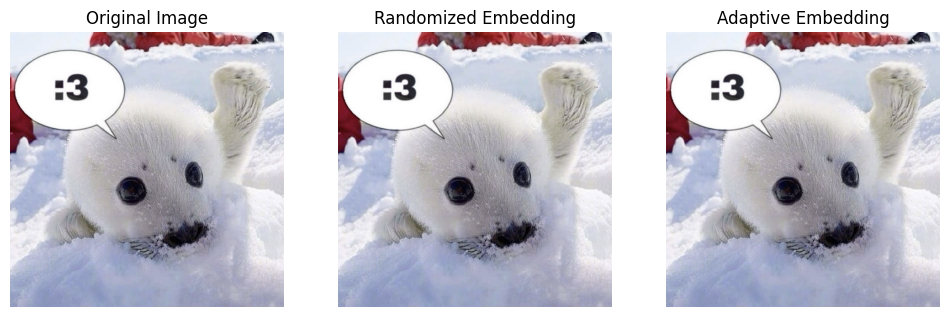

In [18]:
# Display Results to Analyze

def display_images(original_path, random_path, adaptive_path):
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(Image.open(original_path))
    plt.axis("off")

    # Randomized Embedding
    plt.subplot(1, 3, 2)
    plt.title("Randomized Embedding")
    plt.imshow(Image.open(random_path))
    plt.axis("off")

    # Adaptive Embedding
    plt.subplot(1, 3, 3)
    plt.title("Adaptive Embedding")
    plt.imshow(Image.open(adaptive_path))
    plt.axis("off")

    plt.show()

# Display the images for visual comparison
display_images(original_image_path, encoded_image_path_random, encoded_image_path_adaptive)



### Overall Interpretation and Conclusion

Both **randomized embedding** and **adaptive embedding** seem to be effective in concealing the hidden message, as neither shows noticeable artifacts when compared with the original image. 
Both techniques show promise in reducing detectability. They may benefit from combined/hybrid use to further reduce the likelihood of detection through steganalysis.

# 4. Practical Steganalysis
--------------------------

On RCC there is a directory with 1,000+ images, some of which have secret text hidden in them. Apply everything you have observed in the previous questions to identify which ones and (if possible, decode the message).

**Use anything/everything at your disposal to try and identify the coded images. Use your own code, but also try looking at some of the steganalysis tools and projects listed in the module outline. Note: The encoded images are not all encoded with LSB.**

The images are located in `/project/mpcs56430/2024_steganography`. 

Write a file in the following format to indicate which files have encoded data:
```
file_name | true
file_name | false
```

Include and scripts your write and the output file in your repository.

*Note: I altered my results from part 2b since they did not seem to give valid results.*

### Techniques (from resources in outline):
- **Enhanced LSB Visualization**:
  >This technique emphasizes visually inspecting LSBs. By enhancing the LSBs, patterns may emerge that are otherwise invisible. Such patterns are often evident in images with hidden data, even if they look random.

- **Chi-Square Analysis**:
  >This approach can statistically detect randomness in the LSBs by comparing expected and observed frequencies. An image without hidden data often has non-random patterns in LSBs, while an encoded image tends toward a more uniform (random) distribution, especially if hidden data is random or encrypted.

The program uses the Chi-square test to determine if the image has been modified using LSB steganography. The program also provides an enhanced visualization of the LSBs in the image to help identify any hidden patterns.


#### Note
- I was unable to get my file working on the server (due to strange permission locks), so I downloaded (most) of the data locally and ran it.
- The files are in the repository.

# 5. DNA Steganography
------------------

Earlier in the class, we explored the sensitivity of the third codon position and a way to store data in DNA. The natural evolution of these topics is to consider how to hide messages in DNA. While DNA stenagraphy research is active as a way to watermark genetic sequences, the public accessibilty and obscurity of genomic databases opens up another possibility to hide information "in plain sight".


Devise an approach to hide messages in DNA such that the encoded protein is not changed between the original DNA sequence and the encoded sequence. You may consider adapting the concept of the LSB to DNA translation by observing the redundancy in the codon table -- or something completely novel.

Record a short (< 3 minute) presentation of your approach showing you methodolgy with a simple example. You do not need to code a solution. This problem should highlight your creativity, there is not correct solution. Upload your video to ~[panopto]() and provide a link in `#showcase`.

#### Summary:
Encrypt message in DNA sequence containing 'redundant codons' by mapping each character in the message to a synonymous codon change.

**Encoding Rule**:
  - bit=0, leave the original codon
  - bit=1, substitute with synonymous codon *(one that codes for the same amino acid but has a different third base)*
    
**Encryption**:
- Choose a DNA sequence with synonymous codons in the third position. The third positions will serve as the “bits” in which we hide our message.
- For each codon in the sequence, look at the third base and apply the encoding rule (each bit in the binary message dictates whether we substitute the codon)

This process embeds binary data into the DNA sequence without altering the protein sequence it produces.

**Decoding the Message**:

Reverse the process:
- Look at third codon position for each amino acid
- Map the base substitution back to binary (1 is changed, 0 if unchanged)
- Convert binary message back to text.


#### Panopto URL here

[Video](https://uchicago.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=617d7edd-cd4b-45cf-805a-b2270139dc48)
> https://uchicago.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=617d7edd-cd4b-45cf-805a-b2270139dc48


### Extra Research

> #### Research and Approaches Found:
>
> [Pixel-Intensity Value Decomposition](https://www.researchgate.net/publication/269321813_Steganography_Based_on_Pixel_Intensity_Value_Decomposition)
> - 'Experimental results demonstrate that the proposed technique offers an effective compromise between payload capacity and stego quality of existing embedding techniques based on pixel intensity value decomposition.'
> - Provides more balance based on the pixel intensity.
>
> [LSB Enhancement on Adjacent Pixels](https://www.sciencedirect.com/science/article/abs/pii/S0020025510003713)
> - Apply Laplace distribution and estimate the number of zero pixel difference when computing LBS on adjacent pixels.
>
>
> [Thresholding: Contrasted Scaling](https://www.intechopen.com/chapters/49404)
> - Scaling Factor Threshold for Steganography
> - In LSB contrasted scaling, the LSB of an image is replaced with data bits to hide a secret message. Because the LSB is the least important bit, changing it usually doesn't noticeably change the image.
>
> 
> 
> More Advanced:
> [Two-Component Based LSB](https://www.researchgate.net/publication/264144469_A_New_Approach_for_Information_Security_using_an_Improved_Steganography_Technique)
> - A two components based LSB substitution technique (applied to random pixel  locations).
>   - Embedding secret data in the LSB of blue components and partial green components in the edges of images.
>   - An adaptive LSB Substitution technique for embedding data in MSB's (Most Significant Bits) of red, green, and blue components of  pixels across smooth areas.
> - A hybrid feature detection filter which performs better to predict edge areas (even in noisy conditions).
> - Two-tier seccurity woth AES (Advanced Encryption Standard) and random pixel embedding for text encryption.
> 
> Sidenote - Interesting Embedding Detection:
> [LSB Embedding Detection](https://www.researchgate.net/publication/3338654_Detecting_LSB_steganography_in_color_and_gray-scale_images)
>


### References
#### Problem 1:
- LSB: https://medium.com/@renantkn/lsb-steganography-hiding-a-message-in-the-pixels-of-an-image-4722a8567046
- ASCII to Binary in python: https://stackoverflow.com/questions/9509502/in-python-how-do-you-convert-8-bit-binary-numbers-into-their-ascii-characters
- More LSB Resources: http://www.lia.deis.unibo.it/Courses/RetiDiCalcolatori/Progetti98/Fortini/lsb.html
#### Problem 2:
- Cool History of Steganography: https://www.petitcolas.net/steganography/history.html
- Enhances LSB (Provided): http://www.guillermito2.net/stegano/inplainview/index.html
- More Enhanced LSB (Provided): http://www.guillermito2.net/stegano/tools/index.html
- Stenography in MATLAB: https://www.geeksforgeeks.org/lsb-based-image-steganography-using-matlab/
#### Problem 3:
- Performance Metrics: https://www.geeksforgeeks.org/performance-metrics-for-image-steganography/?ref=oin_asr3
- Pixel Intensity Approach: https://www.researchgate.net/publication/269321813_Steganography_Based_on_Pixel_Intensity_Value_Decomposition
- Scaling Methods: https://en.wikipedia.org/wiki/Feature_scaling
- Random Data Embedding: https://www.sciencedirect.com/science/article/abs/pii/S0167404812001745
- Decoding LSB: https://cdn.aaai.org/IAAI/2003/IAAI03-007.pdf
- Data Hiding Techniques: https://www.sciencedirect.com/science/article/abs/pii/S003132030300284X
- Adaptive embedding: https://www.researchgate.net/publication/220177204_Edge_Adaptive_Image_Steganography_Based_on_LSB_Matching_Revisited
#### Problem 4:
- Chi Square Attack: https://scialert.net/fulltext/?doi=rjit.2013.363.372
- Enhanced LSB: https://ieeexplore.ieee.org/document/7967078
#### Problem 5:
- Hiding Messages in DNA microdots: https://www.nature.com/articles/21092
- DNA steganography: https://microbialcellfactories.biomedcentral.com/articles/10.1186/s12934-020-01387-0